In [284]:
import eventDrivenSimulation as eds
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import showPaper as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [285]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 1500
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [286]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [287]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#1c86ee'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [288]:
df_ue=pd.DataFrame(ue_data)

In [289]:
df_cell = pd.DataFrame(cell_data)

In [290]:
sectors=df_cell['pci'].unique()

In [291]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [292]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [52]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [53]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINRwithCoMP_list=np.array([])
SINRwithCoMP_phaseshiftList=np.array([])
tp_1_list=np.array([])
tp_2_list=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINRwithCoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    #phi=random.gauss(0, math.pi)
    phi=random.gauss(0, math.pi/4)
    SINRwithCoMP_phaseshift=10*np.log10((np.power(A[0]+A[1]*np.cos(phi),2)+np.power(A[1]*np.sin(phi),2))/(np.sum(P[2:])+noise))
    
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINRwithCoMP_list=np.append(SINRwithCoMP_list,10*np.log10(SINRwithCoMP))
    SINRwithCoMP_phaseshiftList=np.append(SINRwithCoMP_phaseshiftList,SINRwithCoMP_phaseshift)

    tp_1_list=np.append(tp_1_list,index[0])
    tp_2_list=np.append(tp_2_list,index[1])

##### Building the dataframe

In [54]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINRwithCoMP_list
df['SINR-CoMP with phaseshift [dB]']=SINRwithCoMP_phaseshiftList
df['TP1']=tp_1_list.astype(int)
df['TP2']=tp_2_list.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Define general parameters for the simulation

In [55]:
max_prb=50 #number of prbs defined by the system bandwidth
ue_nr=15 #number of ues per pci
metric=[1,1] #defines the exponents of the metric (standard metric is pf ->[1,1])

#### Sort out PCIs that have less than ue_nr users -> edge of the Scenario

In [56]:
np.unique(df['TP1'])

array([132, 133, 134, 251, 318, 319, 320, 375, 631, 774, 775, 776, 901])

In [57]:
#check if the number of users (positions) for the serving pci is >10
df_filter=df.groupby('TP1')
count=0
for i in df['TP1'].unique():
    k=df_filter.get_group(i)
    if(len(k)<ue_nr):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['TP1']!=i]
    count+=1

#### Define a cluster

In [59]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [132 318 774 319 776 320 134 133 775]


In [60]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

if following code says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [61]:
index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packet that arrives from a user [Bit]
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

# select only ue_nr of users from given index 
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

#### Test Different clusters

In [62]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [132 318 774 319 776 320 134 133 775]


In [63]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

In [64]:
Cluster=[[319,775],[320,133],[319,775,320,133],[319,775,320,133,774,318,134,776]]

In [65]:
X={}
cluster_nr=0
for cluster in Cluster:
    #r='random' 
    r='deterministic'

    mu=4
    env=simpy.Environment()
    sched_l=[]
    sched3=eds.sched_inst(env)
    for i in cluster:
        sched1=eds.sched_inst(env)
        sched_l.append(eds.sched_inst(env))

    index=np.zeros([len(cluster),ue_nr])
    for i in np.arange(0,len(cluster)):
        index[i,:]=np.arange(0,ue_nr)
    index=index.astype(int)

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    if(r=='random'):
        counter=0
        for i in cluster:
            index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
            counter+=1    
    ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

    prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

    env=simpy.Environment()

    SCHEDULE_T=2 #Clock of scheduler -> every 2ms

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_per_pci[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))


    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_per_pci[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        prb_number_normal=max_prb-prb_number_comp[i]
        env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=2000
    env.run(until=timer)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    X[cluster_nr]=x
    cluster_nr+=1

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


In [66]:
xxx=np.append(np.array(list(X[0])),np.array((list(X[1]))))

size=2
10% Quantil: -33.27862799282511
90% Quantil: 85.34350728540142
50% Quantil (Median): -7.585154126070609
size=4
10% Quantil: -33.77008466098056
90% Quantil: 109.8892103461066
50% Quantil (Median): -6.146482245935697
size=9
10% Quantil: -38.317899315116456
90% Quantil: 127.9847724672044
50% Quantil (Median): 6.522603194287779


<Figure size 600x600 with 0 Axes>

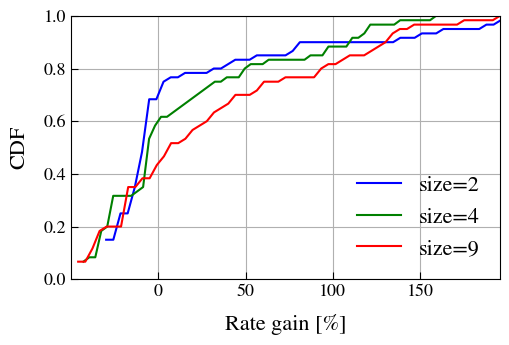

In [68]:
sh.cdf_3(xxx,'size=2','blue',X[2],'size=4','green',X[3][0:60],'size=9','red','',min(x),max(x),'Rate gain [%]',60)

C=2
10% Quantil: -33.27862799282511
90% Quantil: 85.34350728540142
50% Quantil (Median): -7.585154126070609
C=4
10% Quantil: -33.77008466098056
90% Quantil: 109.8892103461066
50% Quantil (Median): -6.146482245935697


<Figure size 600x600 with 0 Axes>

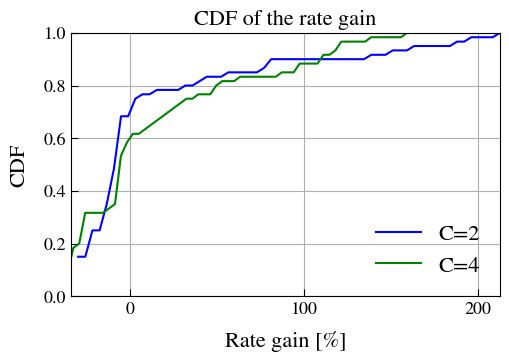

In [106]:
sh.cdf_2(xxx,'C=2','blue',X[2],'C=4','green','CDF of the rate gain',min(xxx),max(xxx),'Rate gain [%]',60)

In [70]:
print(np.mean(xxx))
print(np.mean(X[2]))
print(np.mean(X[3][0:60]))

12.631056440061258
13.082358980734499
27.3741380329276


In [71]:
lat=np.array([])
lon=np.array([])
for i in ue_all:
    lat=np.append(lat,i.x)
    lon=np.append(lon,i.y)
df_res['latitude']=lat
df_res['longitude']=lon

In [73]:
#df['latitude']=df['lat']
#df['longitude']=df['lon']
#df_r=df[df['SINR-CoMP [dB]']-df['SINR [dB]']>6]
#df_r2=df[df['SINR-CoMP [dB]']-df['SINR [dB]']<6]

In [91]:
df_c2=df_cluster
df_c2['mR gain']=xxx
df_r=df_c2[df_c2['mR gain']>1]
df_r2=df_c2[df_c2['mR gain']<1]

<ipython-input-91-5c9de2c02062>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c2['mR gain']=xxx


In [93]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    if(cell['pci'] in [319,775]):
        cell_color = '#1c86ee'
    elif(cell['pci'] in [320,133]):
        cell_color = '#f39f18'
    else:
        cell_color = '#888888'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)

    
    def plotDotGreen(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='green').add_to(ul_scenario_map)
    def plotDotRed(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='red').add_to(ul_scenario_map)

    df_r.apply(plotDotGreen, axis = 1)
    df_r2.apply(plotDotRed, axis = 1)
    


display(ul_scenario_map)

In [96]:
df_c2=df_cluster
df_c2['mR gain']=X[2]
df_r=df_c2[df_c2['mR gain']>1]
df_r2=df_c2[df_c2['mR gain']<1]

<ipython-input-96-aec023298634>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c2['mR gain']=X[2]


In [97]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    if(cell['pci'] in [319,775,320,133]):
        cell_color = '#1c86ee'
    else:
        cell_color = '#888888'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)

    
    def plotDotGreen(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='green').add_to(ul_scenario_map)
    def plotDotRed(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='red').add_to(ul_scenario_map)

    df_r.apply(plotDotGreen, axis = 1)
    df_r2.apply(plotDotRed, axis = 1)
    


display(ul_scenario_map)

In [98]:
df_cluster=df_res[0:60]
df_r=df_cluster[df_cluster['mR gain']>1]
df_r2=df_cluster[df_cluster['mR gain']<1]

In [99]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    if(cell['pci'] in [319,775,320,133,774,318,134,776]):
        cell_color = '#1c86ee'
    else:
        cell_color = '#888888'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)

    
    def plotDotGreen(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='green').add_to(ul_scenario_map)
    def plotDotRed(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='red').add_to(ul_scenario_map)

    df_r.apply(plotDotGreen, axis = 1)
    df_r2.apply(plotDotRed, axis = 1)
    


display(ul_scenario_map)

In [207]:
cluster=[319,775,320,133]

In [231]:
cluster=[319,775,320,133]
x_res=np.array([])
cluster_nr=0
Index={}
for i in np.arange(0,100):
    r='random' 
    #r='deterministic'

    mu=4
    env=simpy.Environment()
    sched_l=[]
    sched3=eds.sched_inst(env)
    for i in cluster:
        sched1=eds.sched_inst(env)
        sched_l.append(eds.sched_inst(env))

    index=np.zeros([len(cluster),ue_nr])
    for i in np.arange(0,len(cluster)):
        index[i,:]=np.arange(0,ue_nr)
    index=index.astype(int)

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    if(r=='random'):
        counter=0
        for i in cluster:
            index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
            counter+=1    
    ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

    prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

    env=simpy.Environment()

    SCHEDULE_T=2 #Clock of scheduler -> every 2ms

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_per_pci[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))


    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_per_pci[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        prb_number_normal=max_prb-prb_number_comp[i]
        env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=2000
    env.run(until=timer)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    x_res=np.append(x_res,np.mean(x))
    Index[cluster_nr]=index
    cluster_nr+=1

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


ValueError: amount(=0.0) must be > 0.

In [ ]:
x_res

In [ ]:
cluster=[319,775]
x_res2=np.array([])
cluster_nr=0
for i in np.arange(0,100):
    r='random' 
    #r='deterministic'

    mu=4
    env=simpy.Environment()
    sched_l=[]
    sched3=eds.sched_inst(env)
    for i in cluster:
        sched1=eds.sched_inst(env)
        sched_l.append(eds.sched_inst(env))

    index=Index[cluster_nr]

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    if(r=='random'):
        counter=0
        for i in cluster:
            index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
            counter+=1    
    ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

    prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

    env=simpy.Environment()

    SCHEDULE_T=2 #Clock of scheduler -> every 2ms

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_per_pci[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))


    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_per_pci[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        prb_number_normal=max_prb-prb_number_comp[i]
        env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=2000
    env.run(until=timer)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    x_res2=np.append(x_res2,np.mean(x))
    cluster_nr+=1

In [ ]:
cluster=[320,133]
x_res3=np.array([])
cluster_nr=0
for i in np.arange(0,100):
    r='random' 
    #r='deterministic'

    mu=4
    env=simpy.Environment()
    sched_l=[]
    sched3=eds.sched_inst(env)
    for i in cluster:
        sched1=eds.sched_inst(env)
        sched_l.append(eds.sched_inst(env))

    index=Index[cluster_nr]

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    if(r=='random'):
        counter=0
        for i in cluster:
            index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
            counter+=1    
    ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

    prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

    env=simpy.Environment()

    SCHEDULE_T=2 #Clock of scheduler -> every 2ms

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_per_pci[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))


    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_per_pci[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        prb_number_normal=max_prb-prb_number_comp[i]
        env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=2000
    env.run(until=timer)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    x_res=np.append(x_res,np.mean(x))
    Index[cluster_nr]=index
    cluster_nr+=1

In [274]:
#df.to_csv('ue_data_pandas')

In [275]:
#df2=pd.read_csv('ue_data_pandas')